In [ ]:
ClearAll["Global`*"]

In [ ]:
(* bad betas indices causing bumps when using `solve_ivp` *)
badIndices = {
    {7, 8},
    {7, 9},
    {8, 6},
    {8, 7},
    {8, 8},
    {8, 9},
    {9, 4},
    {9, 5},
    {9, 6},
    {9, 7},
    {9, 8},
    {9, 9}
};

In [ ]:
(* --- Setup --- *)
Nval = 100; (* number of nodes *)
I0 = 10; (* initial infected *)

tMax = 20; (* TODO: could increase to 100 *)
mu = 1; (* recovery rate mu is fixed *)
Print["N = ", Nval, ", I0 = ", I0, ", mu = ", mu, ", tMax = ", tMax];

(* Check for various values of (beta1, beta2) pairs *)
iMax = 10;
jMax = 10;

In [13]:
eps = 10^-1; (* shift for esp to not start with 0 *)
beta1Vec = Table[N[(i + eps) / Nval], {i, 0, iMax}];
beta2Vec = Table[N[(j + eps) / (Nval^2)], {j, 0, jMax}];

(* Create all combinations (grid points) using `Tuples` *)
betaPairs = Tuples[{beta1Vec, beta2Vec}];

Print["Generated ", Length[betaPairs], " (beta1, beta2) pairs: "];
Print["beta1 \t beta2"]
Print[MatrixForm[Take[betaPairs, 5]]];

Generated 121 (beta1, beta2) pairs: 
beta1 	 beta2
0.001     0.00001

0.001     0.00011

0.001     0.00021

0.001     0.00031

0.001     0.00041


In [21]:
constructODEs[n_, beta1_, beta2_, mu_] := Module[{odes, vars, k},
  Clear[a, b, c, p];
  a[k_] := beta1 k (n - k);
  b[k_] := beta2 Binomial[k, 2] (n - k);
  c[k_] := mu k;

  vars = Table[p[k][t], {k, 0, n}];

  odes = Table[
    Which[
     (* Boundary state k = 0 *)
     k == 0,
     p[k]'[t] == c[k + 1] p[k + 1][t],

     (* Boundary state k = N *)
     k == n,
     p[k]'[t] == (a[k - 1] + b[k - 1]) p[k - 1][t] - c[k] p[k][t],

     (* Interior states 1 <= k <= N - 1 *)
     True,
     p[k]'[t] == (a[k - 1] + b[k - 1]) p[k - 1][t] - (a[k] + b[k] + c[k]) p[k][t] + c[k + 1] p[k + 1][t]
     ],
    {k, 0, n}
    ];

  {odes, vars} (* Return both odes and vars *)
];

In [ ]:
(* Inside the Table loop generating expectedValueFunctionsList *)
solutionFuncs = NDSolveValue[
                   Join[odes, p0],
                   Table[p[k], {k, 0, Nval}],
                   {t, 0, tMax},
                   MaxSteps -> 100000, (* Maybe increase MaxSteps too *)
                   AccuracyGoal -> 10, (* Default is Automatic, often around 8. Increase *)
                   PrecisionGoal -> 10  (* Default is Automatic. Increase *)
                 ];

In [ ]:
expectedValueFunctionsList = Table[
   Module[{
     beta1 = N[pair[[1]]],
     beta2 = N[pair[[2]]],
     odes,
     vars,
     p0,
     solutionFuncs,
     expectedValueFunc
     },
    Print["Running with current pair (beta1, beta2) = ", beta1, ", ", beta2];
    {odes, vars} = constructODEs[Nval, beta1, beta2, mu];
    p0 = Table[p[k][0] == If[k == I0, 1.0, 0.0], {k, 0, Nval}];
    
    (* Solve the system numerically *)
    (* TODO: adjust MaxSteps *)
    (* TODO: maybe NDSolve is using large steps *)
    (* TODO: try ExplicitRungeKutta *)
    solutionFuncs = NDSolveValue[
                         Join[odes, p0],
                         Table[p[k], {k, 0, Nval}], (* TODO: can't use vars? *)
                         {t, 0, tMax}];
    (* Method -> "ExplicitRungeKutta" *)
    
    
    If[ (* if NDSolve fails to find solution *)
        Head[solutionFuncs] =!= List || Length[solutionFuncs] != Nval + 1,
        Print["NDSolve failed for current beta pair"];
        Missing["NDSolveFailed"],
        (* else, return the expected value, note shift index k -> k + 1 *)
        expectedValueFunc[t_?NumericQ] := Sum[k * solutionFuncs[[k + 1]][t], {k, 0, Nval}];
        Print["Done"];
        expectedValueFunc]
    ], {pair, betaPairs} (* for all (beta1, beta2) pairs *)
];


Running with current pair (beta1, beta2) = 0.001, 0.00001


NDSolveValue::ndstf: At t == 1.62519, system appears to be stiff. Methods Automatic, BDF, or StiffnessSwitching may be more appropriate.

Done
Running with current pair (beta1, beta2) = 0.001, 0.00011


NDSolveValue::ndstf: At t == 0.951014, system appears to be stiff. Methods Automatic, BDF, or StiffnessSwitching may be more appropriate.

Done
Running with current pair (beta1, beta2) = 0.001, 0.00021


NDSolveValue::ndstf: At t == 0.707566, system appears to be stiff. Methods Automatic, BDF, or StiffnessSwitching may be more appropriate.

General::stop: Further output of NDSolveValue::ndstf will be suppressed during this calculation.

Done
Running with current pair (beta1, beta2) = 0.001, 0.00031
Done
Running with current pair (beta1, beta2) = 0.001, 0.00041
Done
Running with current pair (beta1, beta2) = 0.001, 0.00051
Done
Running with current pair (beta1, beta2) = 0.001, 0.00061
Done
Running with current pair (beta1, beta2) = 0.001, 0.00071
Done
Running with current pair (beta1, beta2) = 0.001, 0.00081
Done
Running with current pair (beta1, beta2) = 0.001, 0.00091
Done
Running with current pair (beta1, beta2) = 0.001, 0.00101
Done
Running with current pair (beta1, beta2) = 0.011, 0.00001
Done
Running with current pair (beta1, beta2) = 0.011, 0.00011
Done
Running with current pair (beta1, beta2) = 0.011, 0.00021
Done
Running with current pair (beta1, beta2) = 0.011, 0.00031
Done
Running with current pair (beta1, beta2) = 0.011, 0.00041
Done
Running with current pair (beta1, beta2) = 0.011, 0.00051
Done
Running with current pair (beta1, beta2) = 0.011, 0.00061
Done
Running with current pair (beta1, beta2) = 0.011, 

Plotting ...


-Graphics-
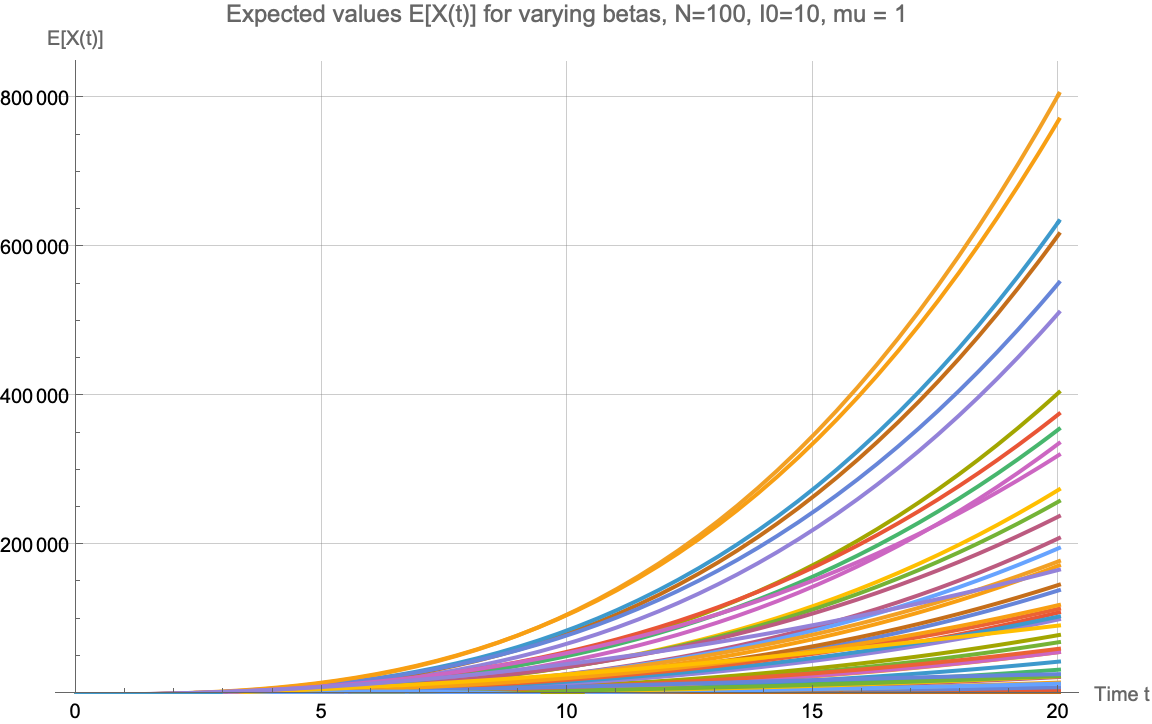

In [107]:
pltLabel = Row[{"Expected values E[X(t)] for varying betas, N=", Nval, ", I0=", I0, ", mu = ", mu}];

(* No legendLabels *)

Print["Plotting ..."];
plotExVals = Plot[
   Evaluate[#[t] & /@ expectedValueFunctionsList],
   {t, 0, tMax},
   AxesLabel -> {"Time t", "E[X(t)]"},
   PlotLabel -> pltLabel,
   PlotStyle -> Thick,
   (* PlotLegends -> LineLegend[Automatic, legendLabels], *)
   GridLines -> Automatic,
   ImageSize -> Large,
   PlotRange -> {0, All} (* y-axis should start at 0 *)
];
plotExVals

In [108]:
(* Convert badIndices to actual bad {beta1, beta2} pairs *)
badBetaPairs = {beta1Vec[[#[[1]]]], beta2Vec[[#[[2]]]]} & /@ badIndices;

In [110]:
(* Generate list of plot styles based on bad beta pairs *)
plotStylesList = Table[
   If[MemberQ[badBetaPairs, betaPairs[[i]]],
      {Thick, Red}, (* bad beta pair *)
      {Thin, Black}
   ], {i, 1, Length[betaPairs]}
];

Plotting ...


-Graphics-
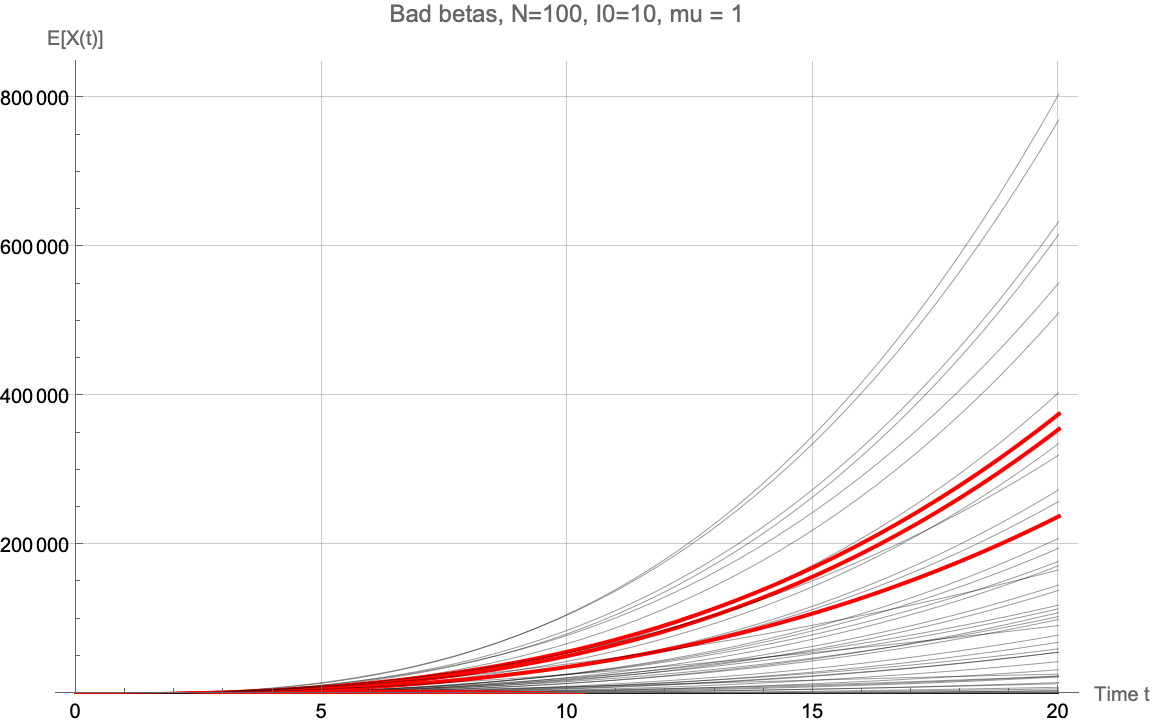

In [115]:
pltLabel = Row[{"Bad betas, N=", Nval, ", I0=", I0, ", mu = ", mu}];

Print["Plotting ..."];
plotExVals = Plot[
   Evaluate[#[t] & /@ expectedValueFunctionsList],
   {t, 0, tMax},
   AxesLabel -> {"Time t", "E[X(t)]"},
   PlotLabel -> pltLabel,
   PlotStyle -> plotStylesList, (* color bad beta pairs curves red *)
   GridLines -> Automatic,
   ImageSize -> Large,
   PlotRange -> {0, All} (* y-axis should start at 0 *)
];
plotExVals